# 21-01 주제분석 2주차 패키지

- 주제분석 2주차 분석 툴은 Python/R 둘 다 가능합니다. 
    - 1-3주차 패키지 문제의 조건 및 힌트는 Python을 기준으로 하지만, R을 사용해도 무방합니다.
    - 다만 2/3주차의 머신러닝/딥러닝 모듈을 편하게 사용하기 위해서는 Python이 더 편할겁니다.

- 제출형식은 pdf/html/doc/ppt 등 발표가 가능하면 괜찮습니다. 하지만 html로 주시면 가장 감사합니다.

- 패키지 과제 발표는 세미나 쉬는시간 이후에 하게 되며, 역시 랜덤으로 5시00분에 발표됩니다.

- 제출기한은 목요일 자정까지이며 지각시 벌금 5000원이 있습니다. 미제출 시 만원입니다. 
    - 패키지 2회 무단 미제출 시 퇴출이니 유의해 주세요.

In [1]:
import pandas as pd 
import numpy as np

- 이번주에 다룰 내용은 test_set분리/릿지회귀/LGBM입니다.
- 더불어서 다뤄지지는 내용은 data leakage 방지(test set 사용하지 않기), 하이퍼 파라미터 튜닝 방법입니다.
- 최대한 생각할 수 있는 여지들을 넣으려고 했습니다.
    - 데이터분석을 할 때 언제나 고민하고 생각하면서 해야 불필요한 삽질을 안할 수 있습니다.
    - 더불어서 주제분석/공모전 때 중요한건 fancy한 모델을 썼느냐 아니냐보다 논리와 결과에 대한 해석입니다.

## 1. 데이터 분할

### 1.1 데이터 불러오기

`trian.csv`와 `test.csv`를 불러오세요.

- train은 `transaction_year`가 5 미만인 경우,
- test는  `transaction_year`가 5인 경우

In [2]:
train = pd.read_csv('train.csv')
#test=  pd.read_csv('test.csv')

### 1.2 단위 수정

- x와 y도 분리해두세요.
- train에만 일단 적용해주세요. 우린 아직 test데이터를 보지 못했습니다.

In [3]:
train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]
#train_y = np.sqrt(train.loc[:, ['price']])

#test_x = test.drop(['price'], axis = 1)
#test_y = np.sqrt(test.loc[:, ['price']])

In [4]:
train_x.tail()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
422159,강일동,강일리버파크2단지,84.74,6,4,8,-2.204364e-15,1.000000e+00
422160,강일동,고덕리엔파크2단지,59.83,7,4,6,1.000000e+00,4.892397e-16
422161,강일동,강일리버파크5단지,59.87,1,4,8,1.000000e+00,4.892397e-16
422162,강일동,강일리버파크4단지,84.83,9,4,8,5.879543e-15,-1.000000e+00
422163,강일동,강일리버파크9단지,84.74,13,4,8,5.879543e-15,-1.000000e+00


In [5]:
train_y.head()

,price
0,70000
1,100500
2,65800
3,30500
4,30500


### 1.3 validation set 분할 - 첫번째

- 사이킷런의 train_test_split을 통해 train데이터를 8:2로 validation set을 만들어주세요.
- 즉 train중에서 train/val이 있고, test set이 따로 존재합니다.
- test set은 전처리 과정에서 절대 사용되지 않을 예정입니다.

In [6]:
from sklearn.model_selection import train_test_split

train_tune_x, val_x, train_tune_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=34)

### 1.4 질문

- 이렇게 데이터를 나눌 경우 어떤 문제가 발생할 수 있을까요?
    - 힌트) 현재 데이터는 관측된 시간이 존재합니다.

In [7]:
del(train_tune_x)
del(train_tune_y)
del(val_x)
del(val_y)

### 1.5 validation set 분할 - 두번째

- `transaction_year == 4`인  행을 validation으로 지정해서 분할하세요.

In [8]:
val_x = train_x[train['transaction_year'] == 4]
val_y = train_y[train['transaction_year'] == 4]

In [9]:
train_tune_x = train_x[train['transaction_year'] < 4]
train_tune_y = train_y[train['transaction_year'] < 4]

In [10]:
train_tune_x.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
0,사직동,광화문풍림스페이스본(9-0),95.88,6,0,5,-1.000000e+00,-1.836970e-16
1,사직동,광화문풍림스페이스본(9-0),108.55,11,0,5,-2.449294e-16,1.000000e+00
2,사직동,광화문풍림스페이스본(9-0),94.51,1,0,5,-2.449294e-16,1.000000e+00
3,수송동,로얄팰리스스위트,42.87,8,0,8,-1.000000e+00,-1.836970e-16
4,수송동,로얄팰리스스위트,39.67,15,0,8,1.000000e+00,3.061617e-16


### 1.5 캣부스트 인코딩 전에

- 일단 캣부스트 인코딩을 위해 다음을 설치하세요.

In [11]:
! pip install category_encoders

In [12]:
from category_encoders.cat_boost import CatBoostEncoder

### 1.6 캣부스트 인코딩

- 방금까지 trainset을 분할했죠? 그 분할된 것을 캣부스트 인코딩의 인자로 받을 겁니다.
- train에서 분할된 train을 인코딩을 위한 학습으로 사용해서, 이를 validation_x에 적용합니다.
- 해당 결과를 `head()`를 통해 보여주세요.

In [13]:
train_x.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
0,사직동,광화문풍림스페이스본(9-0),95.88,6,0,5,-1.000000e+00,-1.836970e-16
1,사직동,광화문풍림스페이스본(9-0),108.55,11,0,5,-2.449294e-16,1.000000e+00
2,사직동,광화문풍림스페이스본(9-0),94.51,1,0,5,-2.449294e-16,1.000000e+00
3,수송동,로얄팰리스스위트,42.87,8,0,8,-1.000000e+00,-1.836970e-16
4,수송동,로얄팰리스스위트,39.67,15,0,8,1.000000e+00,3.061617e-16


In [14]:
def catboost_encoder(train_x, train_y, test_x):
  cate_var = list(train_x.select_dtypes(include=['object']))
  encoder = CatBoostEncoder()
  cbe_train_x = encoder.fit_transform(train_x[cate_var], train_y)
  cbe_test_x = encoder.transform(test_x[cate_var])
  cbe_train_result = (np.concatenate((cbe_train_x, train_x.loc[:,['exclusive_use_area', 'floor', 'transaction_year', 
                                                                  'until_trans', 'sin_time', 'cos_time']]), axis=1))
  cbe_test_result = (np.concatenate((cbe_test_x, test_x.loc[:,['exclusive_use_area', 'floor', 'transaction_year', 
                                                               'until_trans', 'sin_time', 'cos_time']]), axis=1))
  cbe_final_train = pd.DataFrame(cbe_train_result, columns= train_x.columns)
  cbe_final_test = pd.DataFrame(cbe_test_result, columns= test_x.columns)
  return(cbe_final_train, cbe_final_test)

In [15]:
feature_list = list(train_tune_x.columns)

In [16]:
CBE_encoder = CatBoostEncoder()
train_tune_cbe = CBE_encoder.fit_transform(train_tune_x[feature_list], train_tune_y)
val_cbe = CBE_encoder.transform(val_x[feature_list])

In [17]:
val_cbe.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
2451,89176.597368,86280.203194,107.91,14,4,9,-1.000000e+00,-1.836970e-16
2452,89176.597368,86280.203194,151.81,10,4,9,-1.000000e+00,-1.836970e-16
2453,89176.597368,86280.203194,94.51,2,4,9,-2.449294e-16,1.000000e+00
2454,89176.597368,86280.203194,94.28,12,4,9,-2.449294e-16,1.000000e+00
2455,103789.156533,107170.755379,145.96,13,4,13,-1.000000e+00,-1.836970e-16


## 2. 릿지 회귀 (Ridge Regression)

- 성능이 좋다고 알려진 부스팅모델 두개 하려다가, 그냥 릿지로 선회했습니다!

### 2.1 상관계수 플랏

- 캣부스트 인코딩을 시행한 튜닝을 위한 trainset에 대해 상관계수플랏을 그리세요.
- 해석해주세요. 릿지 회귀가 잘 작동할까요?

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns 

<AxesSubplot:>

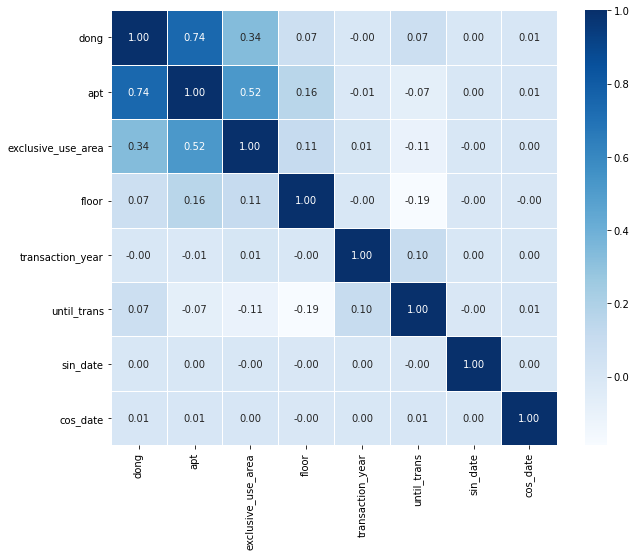

In [19]:
plt.figure(figsize=(10,8))
sns.heatmap(data = train_tune_cbe.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

### 2.2 해석과 무관하게 일단 릿지 튜닝

- mse를 비교해서 튜닝을 진행하세요.
- 릿지의 튜닝파라미터 알파는 0.00001, 0.0001, 0.001, 0.01, 0.1로 설정합니다.
- 알파가 클수록 강한 페널티입니다.
- 튜닝결과를 시각화해주세요.

In [20]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt

In [21]:
best_ridge_score = 1000000
each_score = []
alpha_ridge = [0.000001,0.00001, 0.0001, 0.001, 0.01]

for alpha1 in alpha_ridge:
    ridge_reg = Ridge(alpha = alpha1)
    ridge_reg.fit(train_tune_cbe, train_tune_y)
    pred_y = ridge_reg.predict(val_cbe)
    rmse_ridge = sqrt(mean_squared_error(val_y, pred_y))
    
    each_score.append(rmse_ridge)
    
        # RMSE가 더 작으면 기록합니다.
    if rmse_ridge < best_ridge_score:
        best_ridge_score = rmse_ridge
        best_parameters = {'alpha': alpha1}
        
print(best_parameters)
print(best_ridge_score)
print(each_score)

{'alpha': 1e-06}
14777.881419493004
[14777.881419493004, 14777.88141950204, 14777.881419592415, 14777.881420496142, 14777.881429533425]


### 2.3 튜닝결과 시각화

<AxesSubplot:>

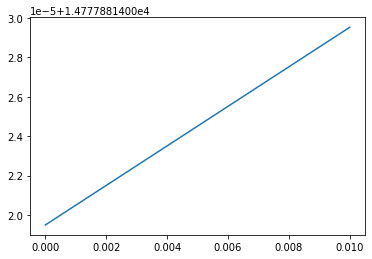

In [22]:
sns.lineplot(x = alpha_ridge, y = each_score)

### 2.4 해석

튜닝 결과에 대한 플랏을 보고 해석을 해주세요.

- 튜닝이 잘되었나요?
- 튜닝이 안되었다면 그 이유는 무엇인가요?

- https://stats.stackexchange.com/questions/81395/relationship-between-ridge-regression-and-pca-regression
    - 수식이 쉽진 않을텐데 그냥 슬쩍 보세요...ㅎㅎㅎ
- https://online.stat.psu.edu/stat508/lesson/5/5.1
    - penn state자료는 맨 아래부분만 보면 됩니다.

### 2.5 그냥 선형 모형으로!

그냥 linear regression을 튜닝을 위한 trainset에 적합시키고, validation set에 대한 rmse를 계산하세요.

- linear regression은 다른 튜닝 파라미터를 필요로하지 않습니다.
- ridge와의 validation rmse를 비교했을 때, 어떤 모형을 쓰는 것이 나을지 말해주세요.

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
lin_reg = LinearRegression()
lin_reg.fit(train_tune_cbe, train_tune_y)
pred_y = lin_reg.predict(val_cbe)
rmse_lin = sqrt(mean_squared_error(val_y, pred_y))
print('RMSE of linear regression is', rmse_lin)

RMSE of linear regression is 14777.8814194924


## 3. LightGBM

강력하면서도 빠른 부스팅 모형인 LGBM에 대해 다룰 예정입니다.

In [25]:
! pip install lightgbm

### 3.1 LightGBM 이해

모형에 대해 아주 기본적인 이해는 필요하겠죠? LGBM의 특징/장점/문제점을 적어주세요.

- 20-01 데마팀 클린업 3주차 혹은 또 다른 데마팀 클린업을 보셔도 괜찮습니다.
- 구글링해도 잘 나옵니다.

### 3.2 LGBM 튜닝

- LGBM의 튜닝파라미터는 많습니다.
- `max_depth`, `learning_rate`, `lambda`, `min_child_samples` 등 다양한데, 패키지에서는 learning rate만 튜닝하도록 하겠습니다.
    - [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.99] 이렇게 튜닝해주세요.
    - 부스팅에서는 일단 learning rate과 iteration의 trade off를 적절하게 고려해줘서 학습속도를 맞춰준다음, 세부적인 튜닝을 하는게 일반적입니다.
- 더하고 싶으면 해서 더 좋은 성능을 내셔도 됩니다! 보통 `enumerate`를 통해 파라미터를 묶어줘서 진행합니다.

In [26]:
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor
# import itertools

In [27]:
best_lgbm_score = 1000000
each_score = []
lr_lgbm = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.99]

In [28]:
for lr in lr_lgbm:
    lgbm_reg = LGBMRegressor(learning_rate = lr)
    lgbm_reg.fit(train_tune_cbe, train_tune_y)
    pred_y = lgbm_reg.predict(val_cbe)
    rmse_lgbm = sqrt(mean_squared_error(val_y, pred_y))
    
    each_score.append(rmse_lgbm)
    
        # RMSE가 더 작으면 기록합니다.
    if rmse_lgbm < best_lgbm_score:
        best_lgbm_score = rmse_lgbm
        best_parameters = {'learning_rate': lr}
        
print(best_parameters)
print(best_lgbm_score)
print(each_score)

{'alpha': 1e-06}
1000000
[417203856.05084056, 144530331.5148534, 134343431.99351662, 125521683.2852912, 132921919.1102039, 172533722.53728354, 159922746.31820524]


### 3.3 튜닝결과 시각화

learning_rate의 변화에 따른 rmse의 변화를 시각화해주세요!

<AxesSubplot:>

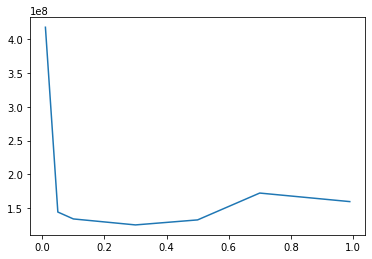

In [29]:
sns.lineplot(x = lr_lgbm, y = each_score)

### 3.4 튜닝에 대하여 알아보자

우리가 한 튜닝방식은 `그리드 서치(Grid Search)`방법입니다. 다른 방법으로는 `Random Search`와 `Bayesian Optimization` 방법이 있습니다.

- 세 가지 방법에 대해서 간단히 설명하고, 장단점을 말해주세요.
- 요즘에는 Neural Process 기반의 Optimization이란 방법도 활발히 연구중이라던데...그냥 그렇다구요 ㅎㅎㅎ 원래 Bayesian Optimization이 Gaussian Process 기반인데, 이걸 뛰어넘는 성능이래요 암튼~

## 4. test set

### 4.1 test set 불러오기

- test set을 불러오고
- X와 y를 분리하세요.

In [30]:
test=  pd.read_csv('test.csv')
test_x = test.drop(['price'], axis = 1)
test_y = test.loc[:, ['price']]

### 4.2 캣부스트 인코딩

- 전체 train set에 대해 캣부스트 인코딩을 시행해주세요.
- 인자에는 train_x/train_y/test_x가 들어갈겁니다.

In [31]:
feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

### 4.3 최적의 파라미터 적합

- 2와 3의 결과에서 최적의 파라미터(모델)을 전체 trainset에 대해 적합하세요.

In [32]:
best_lin_reg = LinearRegression()
best_lin_reg.fit(train_cbe, train_y)

LinearRegression()

In [33]:
best_lgbm_reg = LGBMRegressor(learning_rate = 0.3)
best_lgbm_reg.fit(train_cbe, train_y)

LGBMRegressor(learning_rate=0.3)

### 4.4 test set에 대해 평가

- 두 모델을 test set에 대해 평가해서 비교하세요.

In [34]:
pred_y = best_lgbm_reg.predict(test_cbe)
rmse_best_lgbm = sqrt(mean_squared_error(test_y, pred_y))

pred_y = best_lin_reg.predict(test_cbe)
rmse_best_lin = sqrt(mean_squared_error(test_y, pred_y))

In [35]:
print(rmse_best_lgbm)
print(rmse_best_lin)

12620.16900868891
16350.627412822796
